<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Single-Risk Derivatives Valuation

This part introduces into the modeling and valuation of derivatives instruments (contingent claims) based on a single risk factor (e.g. a stock price, stock index level or interest rate). It also shows how to model and value portfolios composed of such instruments. 

In [1]:
from dx import *
import seaborn as sns; sns.set()

The following **single risk factor valuation classes** are available:

* `valuation_mcs_european_single` for derivatives with European exercise
* `valuation_mcs_american_single` for derivatives with American/Bermudan exercise

## Modeling the Risk Factor

Before moving on to the valuation classes, we need to model an instantiate an underlying risk factor, in this case a `geometric_brownian_motion` object. Background information is provided in the respective part of the documentation about model classes.

In [2]:
r = constant_short_rate('r', 0.06)

In [3]:
me = market_environment('me', dt.datetime(2015, 1, 1))

In [4]:
me.add_constant('initial_value', 36.)
me.add_constant('volatility', 0.2)
me.add_constant('final_date', dt.datetime(2015, 12, 31))
me.add_constant('currency', 'EUR')
me.add_constant('frequency', 'W')
me.add_constant('paths', 25000)

In [5]:
me.add_curve('discount_curve', r)

In [6]:
gbm = geometric_brownian_motion('gbm', me)

## valuation_mcs_european_single

The first instrument we value is a European call option written on the single relevant risk factor as embodied by the `gbm` model object. To this end, we add a **maturity date** to the market environment and a **strike price**.

In [7]:
me.add_constant('maturity', dt.datetime(2015, 12, 31))
me.add_constant('strike', 40.)

To instantiate a the `valuation_mcs_european_single` class, the following information/data is to be provided:

* name as a `string` object
* instance of a model class
* market environment
* payoff of the instrument a `string` object and containing "regular" Python/NumPy code

In [8]:
call_eur = valuation_mcs_european_single(
                name='call_eur',
                underlying=gbm,
                mar_env=me,
                payoff_func='np.maximum(maturity_value - strike, 0)')

In this case, the payoff is that of a regular, plain vanilla European call option. If $T$ is the maturity date, $S_T$ the value of the relevant risk factor at that date and $K$ the strike price, the payoff $h_T$ at maturity of such an option is given by

$$
h_T = \max[S_T - K, 0]
$$

`maturity_value` represents the value vector of the risk factor at maturity. Any other "sensible" payoff definition is possible. For instance, the following works as well: 

In [9]:
payoff = 'np.maximum(np.minimum(maturity_value) * 2 - 50, 0)'

Other standardized payoff elemenets include `mean_value, max_value` and `min_value` representing maturity value vectors with the pathwise means, maxima and minima. Using these payoff elements allows the easy definition of options with **Asian features**.


Having instantiated the valuation class, the `present_value` method returns the present value Monte Carlo estimator for the call option.

In [10]:
call_eur.present_value()

2.181851

Similarly, the `delta` and `vega` methods return the delta and the vega of the option, estimated numerically by a forward difference scheme and Monte Carlo simulation.

In [11]:
call_eur.delta()

0.43630000000000002

In [12]:
call_eur.vega()

14.1882

This approach allows to work with such a valuation object similar to an analytical valuation formula like the one of Black-Scholes-Merton (1973). For example, you can **estimate and plot present values, deltas, gammas, vegas, thetas and rhos** for a range of different initial values of the risk factor.

In [13]:
%%time
k_list = np.arange(26., 46.1, 2)
pv = []; de = []; ve = []; th = []; rh = []; ga = []
for k in k_list:
    call_eur.update(strike=k)
    pv.append(call_eur.present_value())
    de.append(call_eur.delta(0.5))
    ve.append(call_eur.vega(0.2))
    th.append(call_eur.theta())
    rh.append(call_eur.rho())
    ga.append(call_eur.gamma())

CPU times: user 5.92 s, sys: 878 ms, total: 6.8 s
Wall time: 6.8 s


In [14]:
%matplotlib inline

There is a little plot helper function available to plot these statistics conveniently.

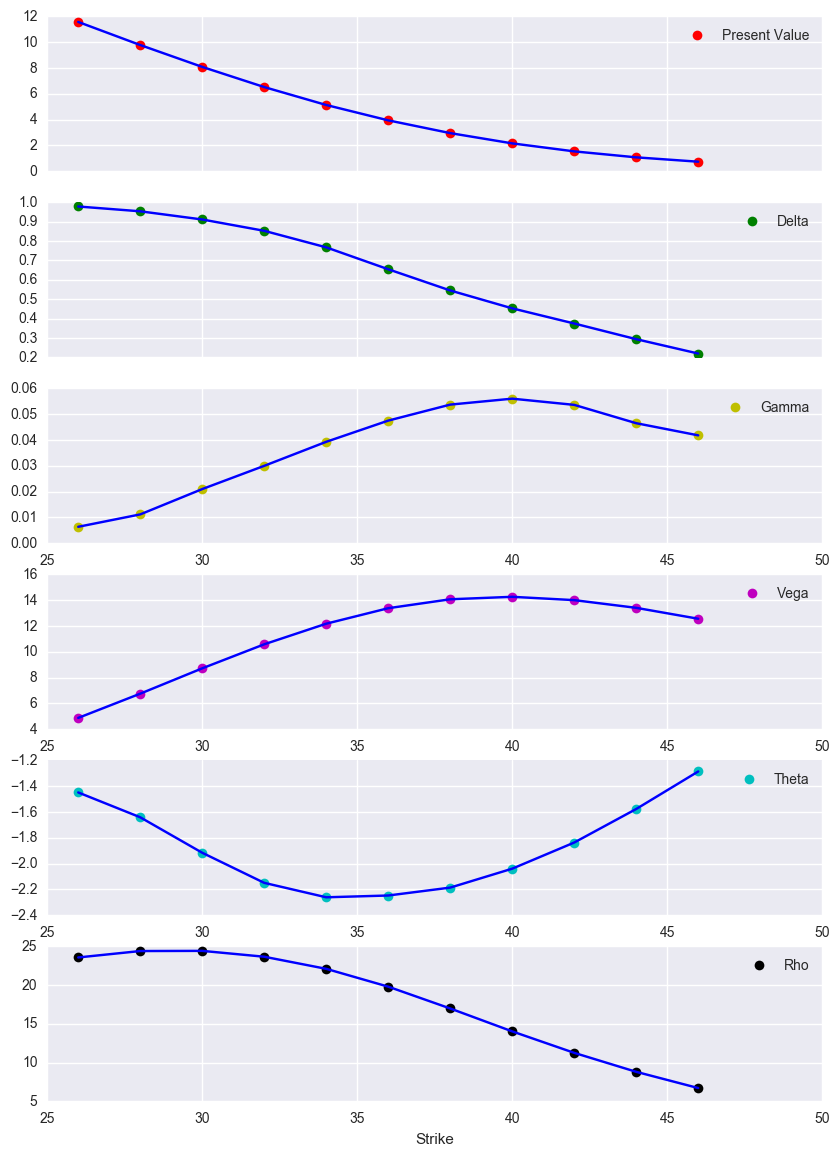

In [15]:
plot_option_stats_full(k_list, pv, de, ga, ve, th, rh)

## valuation_mcs_american_single

The modeling and valuation of derivatives with American/Bermudan exercise is almost completely the same as in the more simple case of European exercise.

In [16]:
me.add_constant('initial_value', 36.)
  # reset initial_value

In [17]:
put_ame = valuation_mcs_american_single(
                name='put_eur',
                underlying=gbm,
                mar_env=me,
                payoff_func='np.maximum(strike - instrument_values, 0)')

The only difference to consider here is that for American options where exercise can take place at any time before maturity, the inner value of the option (payoff of immediate exercise) is relevant over the whole set of dates. Therefore, `maturity_value` needs to be replaced by `instrument_values` in the definition of the payoff function.

In [18]:
put_ame.present_value()

4.452

Since DX Analytics relies on Monte Carlo simulation and other *numerical* methods, the calculation of the delta and vega of such an option is identical to the European exercise case.

In [19]:
put_ame.delta()

-0.66549999999999998

In [20]:
put_ame.vega()

10.312200000000001

In [21]:
%%time
k_list = np.arange(26., 46.1, 2.)
pv = []; de = []; ve = []
for k in k_list:
    put_ame.update(strike=k)
    pv.append(put_ame.present_value())
    de.append(put_ame.delta(.5))
    ve.append(put_ame.vega(0.2))

CPU times: user 12.9 s, sys: 759 ms, total: 13.7 s
Wall time: 13.1 s


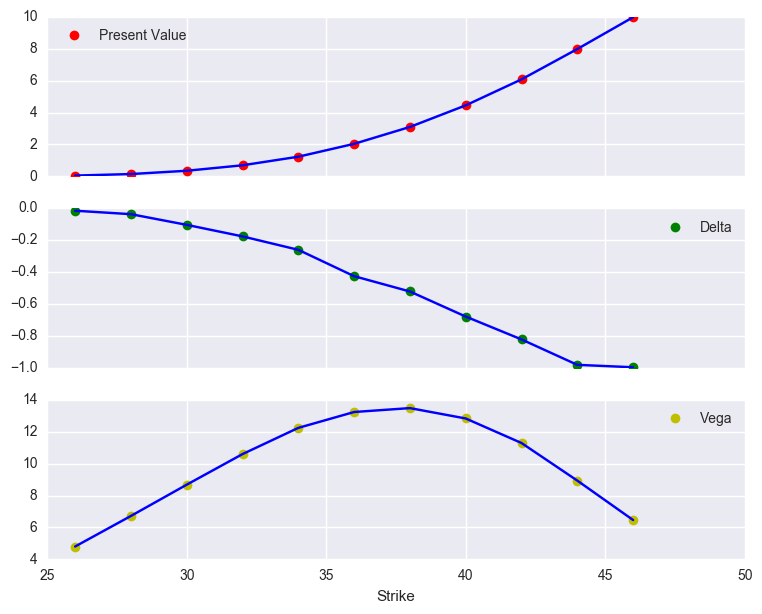

In [22]:
plot_option_stats(k_list, pv, de, ve)

## Portfolio Valuation

In general, market players (asset managers, investment banks, hedge funds, insurance companies, etc.) have to value not only single derivatvies instruments but rather portfolios composed of several derivatives instruments. A consistent derivatives portfolio valuation is particularly important when there are multiple derivatives written on the same risk factor and/or correlations between different risk factors.

These are the classes availble for a consistent portfolio valuation:

* `derivatives_position` to model a portfolio position
* `derivatives_portfolio` to model a derivatives portfolio

### derivatives_position

We work with the `market_environment` object from before and add information about the risk factor model we are using.

In [23]:
me.add_constant('model', 'gbm')

A derivatives position consists of "data only" and not instantiated model or valuation objects. The necessary model and valuation objects are instantiated during the portfolio valuation.

In [24]:
put = derivatives_position(
                name='put',  # name of position
                quantity=1,  # number of instruments
                underlyings=['gbm'],  # relevant risk factors
                mar_env=me,  # market environment
                otype='American single',  # the option type
                payoff_func='np.maximum(40. - instrument_values, 0)')
                    # the payoff funtion

The method `get_info` prints an overview of the all relevant information stored for the respective `derivatives_position` object.

In [25]:
put.get_info()

NAME
put 

QUANTITY
1 

UNDERLYINGS
['gbm'] 

MARKET ENVIRONMENT

**Constants**
paths 25000
strike 40.0
volatility 0.2
initial_value 36.0
maturity 2015-12-31 00:00:00
model gbm
final_date 2015-12-31 00:00:00
frequency W
currency EUR

**Lists**

**Curves**
discount_curve <dx.frame.constant_short_rate object at 0x106e356d8>

OPTION TYPE
American single 

PAYOFF FUNCTION
np.maximum(40. - instrument_values, 0)


### derivatives_portfolio

The `derivatives_portfolio` class implements the core portfolio valuation tasks. This sub-section illustrates to cases, one with uncorrelated underlyings and another one with correlated underlyings

#### Uncorrelated Underlyings

The first example is based on a portfolio with two single-risk factor instruments on **two different risk factors which are not correlated**. In addition to the `gbm` object, we define a `jump_diffusion` object.

In [26]:
me_jump = market_environment('me_jump', dt.datetime(2015, 1, 1))

In [27]:
me_jump.add_environment(me)
me_jump.add_constant('lambda', 0.8)
me_jump.add_constant('mu', -0.8)
me_jump.add_constant('delta', 0.1)
me_jump.add_constant('model', 'jd')

Based on this new risk factor model object, a European call option is defined.

In [28]:
call_jump = derivatives_position(
                name='call_jump',
                quantity=3,
                underlyings=['jd'],
                mar_env=me_jump,
                otype='European single',
                payoff_func='np.maximum(maturity_value - 36., 0)')

Our **relevant market** now takes on the following form (defined a `dictionary` objects):

In [29]:
risk_factors = {'gbm': me, 'jd' : me_jump}
positions = {'put' : put, 'call_jump' : call_jump}

To instantiate the `derivatives_portfolio` class, a **valuation environment** (instance of `market_environment` class) is needed.

In [30]:
val_env = market_environment('general', dt.datetime(2015, 1, 1))
val_env.add_constant('frequency', 'M')
val_env.add_constant('paths', 50000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
val_env.add_curve('discount_curve', r)

For the **instantiation**, we pass all the elements to the portfolio class.

In [31]:
port = derivatives_portfolio(
            name='portfolio',  # name 
            positions=positions,  # derivatives positions
            val_env=val_env,  # valuation environment
            risk_factors=risk_factors, # relevant risk factors
            correlations=False,  # correlation between risk factors
            fixed_seed=False,  # fixed seed for randon number generation
            parallel=False)  # parallel valuation of portfolio positions

Once instantiated, the method `get_statistics` provides major portfolio statistics like position values, position deltas ans position vegas.

In [32]:
%%time
stats = port.get_statistics()

Totals
 pos_value    34.6770
pos_delta     2.3206
pos_vega     22.1461
dtype: float64
CPU times: user 728 ms, sys: 68.1 ms, total: 796 ms
Wall time: 771 ms


In [33]:
stats

,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,call_jump,call_jump,3,European single,[jd],10.076,EUR,30.228,3.0000,11.2230
1,put,put,1,American single,[gbm],4.449,EUR,4.449,-0.6794,10.9231


The method returns a standard pandas `DataFrame` object with which you can work as you are used to.

In [34]:
stats[['pos_value', 'pos_delta', 'pos_vega']].sum()

pos_value    34.6770
pos_delta     2.3206
pos_vega     22.1461
dtype: float64

The metod `get_values` only calculates the present values of the derivatives instruments and positions and is therefore a bit less compute and time intensive.

In [35]:
%time port.get_values()

Total
 pos_value    34.73486
dtype: float64
CPU times: user 161 ms, sys: 12.3 ms, total: 174 ms
Wall time: 169 ms


,position,name,quantity,otype,risk_facts,value,currency,pos_value
0,call_jump,call_jump,3,European single,[jd],10.09762,EUR,30.29286
1,put,put,1,American single,[gbm],4.44200,EUR,4.44200


The method `get_positions` provides detailed information about the single derivatives positions of the `derivatives_portfolio` object.

In [36]:
port.get_positions()


--------------------------------------------------
NAME
call_jump 

QUANTITY
3 

UNDERLYINGS
['jd'] 

MARKET ENVIRONMENT

**Constants**
paths 50000
volatility 0.2
model jd
currency EUR
lambda 0.8
mu -0.8
initial_value 36.0
final_date 2015-12-31 00:00:00
strike 40.0
delta 0.1
maturity 2015-12-31 00:00:00
starting_date 2015-01-01 00:00:00
frequency M

**Lists**
random_numbers [[[ 1.59911088 -1.4046112  -1.41690211 ..., -0.02367133  0.64452581
    0.83372797]
  [-1.71068746 -0.17718321  1.19908444 ..., -0.12887556  1.84851716
    1.99223491]
  [ 0.91793265  0.527942   -0.51603028 ...,  0.84100797 -1.36662164
   -0.60581475]
  ..., 
  [ 1.2128477  -0.02445883  0.28700922 ..., -0.68947286 -0.04293013
   -0.15945594]
  [-1.32537389 -0.70003276  1.90365643 ..., -0.2332303  -0.0369755
    1.44280306]
  [ 0.20542848 -0.7790572  -0.75625624 ..., -1.470969   -1.00645074
   -0.12511486]]

 [[-2.1046119   1.11433037 -1.44243622 ...,  0.95216647 -0.4916233
    0.14714287]
  [ 0.88624348 -0.10835483

#### Correlated Underlyings

The second example case is exactly the same but now with a **highly positive correlation** between the two relevant risk factors. Correlations are to be provided as a `list`  of `list` objects using the risk factor model names to reference them.

In [37]:
correlations = [['gbm', 'jd', 0.9]]

Except from now passing this new object, the application and usage remains the same.

In [38]:
port = derivatives_portfolio(
            name='portfolio',
            positions=positions,
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            fixed_seed=True,
            parallel=False)

In [39]:
port.get_statistics()

Totals
 pos_value    35.1350
pos_delta     1.6345
pos_vega     21.8606
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,call_jump,call_jump,3,European single,[jd],10.234,EUR,30.702,2.2893,11.0271
1,put,put,1,American single,[gbm],4.433,EUR,4.433,-0.6548,10.8335


The **Cholesky matrix** has been added to the valuation environment (which gets passed to the risk factor model objects).

In [40]:
port.val_env.lists['cholesky_matrix']

array([[ 1.        ,  0.        ],
       [ 0.9       ,  0.43588989]])

Let us pick **two specific simulated paths**, one for each risk factor, and let us visualize these.

In [41]:
path_no = 0
paths1 = port.underlying_objects['gbm'].get_instrument_values()[:, path_no]
paths2 = port.underlying_objects['jd'].get_instrument_values()[:, path_no]

The plot illustrates that the two paths are indeed **highly positively correlated**. However, in this case a **large jump** occurs for the `jump_diffusion` object.

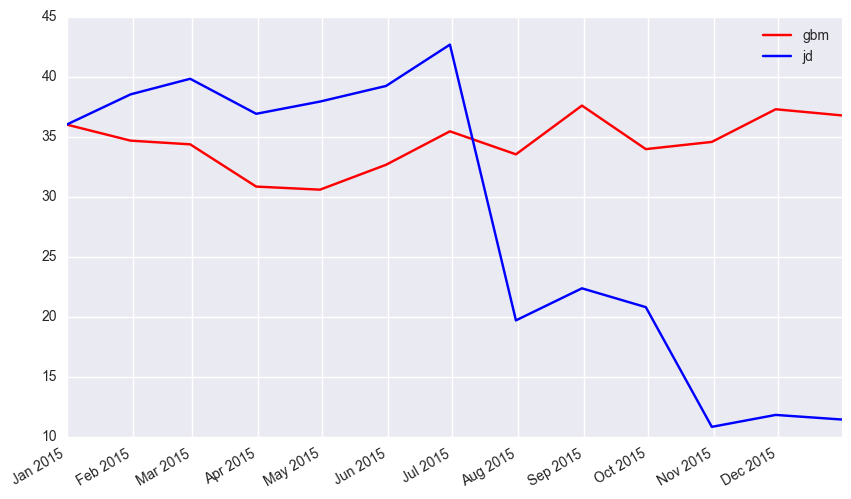

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(port.time_grid, paths1, 'r', label='gbm')
plt.plot(port.time_grid, paths2, 'b', label='jd')
plt.gcf().autofmt_xdate()
plt.legend(loc=0); plt.grid(True)
# highly correlated underlyings
# -- with a large jump for one risk factor

**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)